# Generation of exome coverage projection model from FFPE samples
---

## Background:

DNA extracted from limited amounts of formalin-fixed and paraffin-embedded (FFPE) archived tissue is variable in quality and quantity, resulting in low exome library complexity and leads to reduced coverage depth and experimental failure. Existing depth prediction strategies require prior shallow sequencing, wasteful of time and labor when the failure rate is high. 

## Purpose:

The overall goal of this model is to predict exome depth (or coverage), from limited parameters obtained during the DNA library preparation of samples for suboptimal FFPE DNA samples in order to help guide the decisions whether a sample should be sequenced or not.  

Currently (an older version of) this model is being implemented in a QC tool called [PROCEED](https://share.streamlit.io/danielanach/proceed/main/PROCEED.py) (PROjeCt ExomE Depth) for use by experimental scientists.

---

# Table of contents
1. [Process input data](#process-data)
2. [Train multiple linear regression model](#model-data)
3. [Evaluate model](#evaluate-model)

---

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn import metrics
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings(action='ignore')
%matplotlib inline

/Users/d/conda/lib/python3.9/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
sns.set_context('paper')
    
# Set the font to be serif, rather than sans
sns.set(font='arial', font_scale=1.5)

# Make the background white, and specify the
# specific font family
sns.set_style('white', {'font.family': 'arial', 'axes.grid': False, 
                        'font.size':12, 'axes.labelsize':10})

# 1. Process input data. <a class="anchor" id="process-data"></a>
This data is a compilation of both published and un-published FFPE DNA libraries which have been exome sequenced and includes bulk FFPE samples and laser-capture micro-dissected samples from oral premalignant lesions [1] and breast pre-cancer [2-3]. For which we have both some pre-sequencing, as well as post-sequencing statistics. 


**References:**

> 1. Gutkind,J.S. et al. (2021) Inhibition of mTOR signaling and clinical activity of metformin in oral premalignant lesions. *JCI Insight*, 6.
> 2. Nachmanson,D. et al. The breast pre-cancer atlas illustrates the molecular and micro-environmental diversity of ductal carcinoma in situ. npj Breast Cancer, *In Press*.
> 3. Nachmanson,D. et al. (2020) Mutational profiling of micro-dissected pre-malignant lesions from archived specimens. *BMC Med. Genomics*, 13, 173.

## 1.1 Reading in data frame

In [3]:
data = pd.read_csv('ffpe_DNA_seq_training_data_clean.csv')
print('Data dimensions: {}'.format(data.shape))

Data dimensions: (171, 14)


## 1.2 Choosing representative sample from DNA replicates
In the case that multiple libraries were prepared from the same FFPE DNA extraction, we are only keeping data from one of these libraries. Since decisions about which samples to continue on through exome sequencing typically tend to be those that have little input DNA, we chose to keep the lowest DNA input amount.

In [4]:
data = data.sort_values(by='input_DNA_ng').drop_duplicates(subset='dna',
                                                           keep='first')
print('Data dimensions: {}'.format(data.shape))

Data dimensions: (166, 14)


## 1.3 Statistics of select data features

In [5]:
num_samples = len(data['case'].unique())
print('Number of unique samples: {}'.format(num_samples))

Number of unique samples: 124


Number of libraries represented in each kit

In [6]:
data.groupby(by='kit').size()

kit
Swift 2S           90
Ultra_II_NEB_FS    54
XTHS               22
dtype: int64

Average DNA input as well as the range of represented input values

In [7]:
median_input = np.median(data['input_DNA_ng'])
print('Median DNA input = {} ng'.format(median_input))
print('Range DNA input = ({}, {})'.format(min(data['input_DNA_ng']),
                                          max(data['input_DNA_ng'])))

Median DNA input = 17.15 ng
Range DNA input = (2.0, 309.0)


## 1.4 Explore and visualize all continuous pre-sequencing metrics

How are the continuous features correlated with one another?

In [8]:
data[['pcr_cycles','total_reads_M','post_pcr1_dna','average_coverage']].corr()

,pcr_cycles,total_reads_M,post_pcr1_dna,average_coverage
pcr_cycles,1.000000,-0.348959,-0.015834,-0.720753
total_reads_M,-0.348959,1.000000,-0.168427,0.414528
post_pcr1_dna,-0.015834,-0.168427,1.000000,0.336927
average_coverage,-0.720753,0.414528,0.336927,1.000000


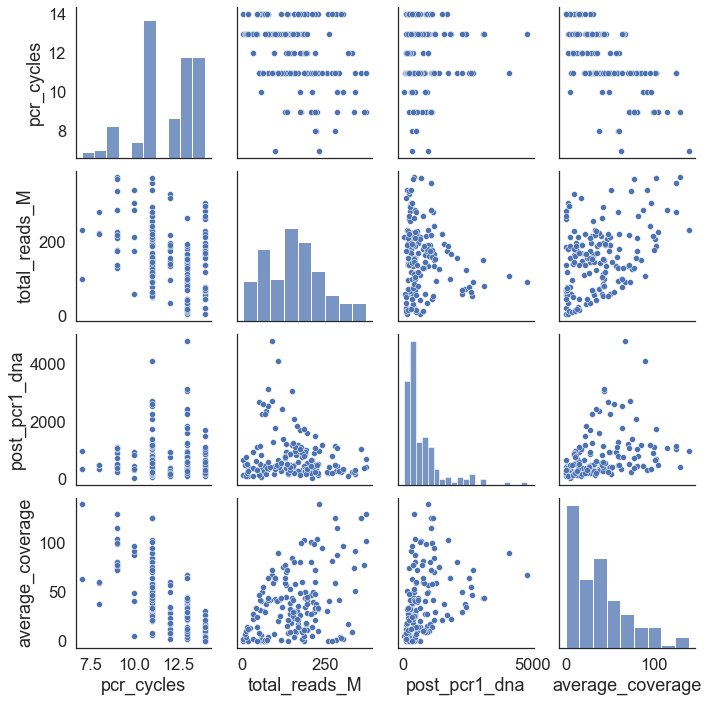

In [9]:
sns.pairplot(data[['pcr_cycles','total_reads_M','post_pcr1_dna','average_coverage']])
plt.show()

All of the variables are correlated with average coverage, so should be useful in a multiple-linear regression model. 

### Plot all the features together, and also include sequencing kit type, to visualize the relationships between them.

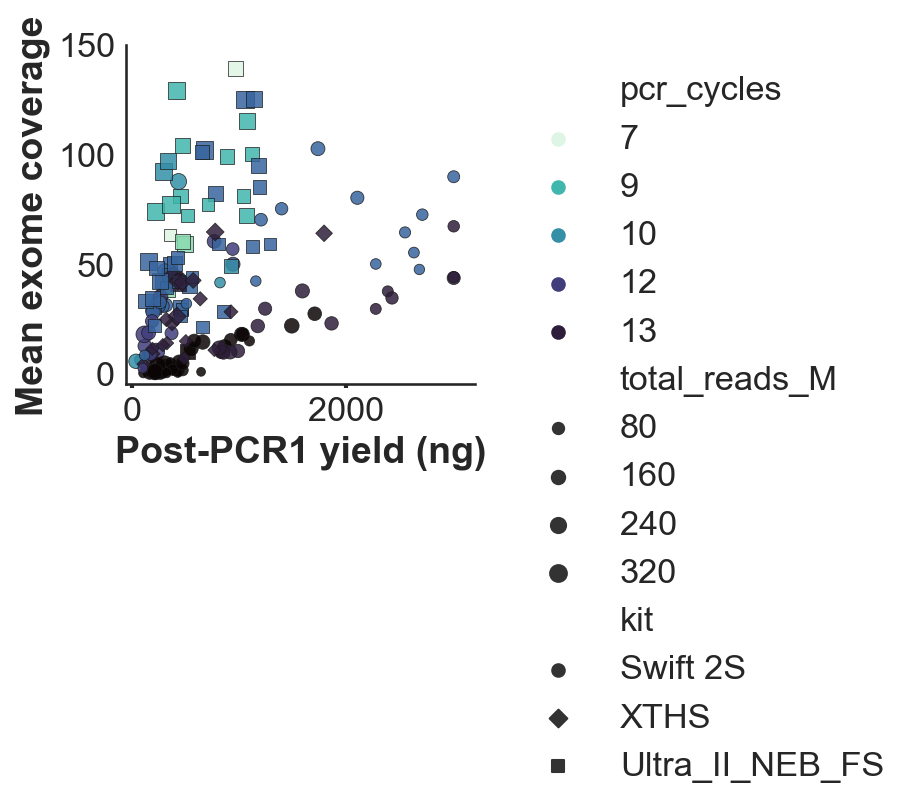

In [10]:
# Note, I am capping the post-pcr1 DNA at 3ug for visualization purposes
data['post_pcr1_dna_clip'] = np.clip(data['post_pcr1_dna'], 
                                     a_min=0, a_max=3000)

plt.figure(figsize=(3,3), dpi=150)

sns.scatterplot(data=data, 
                x='post_pcr1_dna_clip', 
                y='average_coverage', 
                palette='mako_r', 
                edgecolor='k', 
                alpha=0.85, 
                size='total_reads_M', 
                hue='pcr_cycles', 
                style='kit', 
                style_order=['Swift 2S', 'XTHS', 'Ultra_II_NEB_FS'], 
                markers=['o', 'D', 's'], 
                s=200)

plt.xlim(-50, 3200)
plt.ylim(-5, 150)

sns.despine(right=True)

plt.xlabel('Post-PCR1 yield (ng)', fontweight='bold')
plt.ylabel('Mean exome coverage', fontweight='bold')

plt.tick_params(axis='both', which='major', size=2, width=2, 
                direction='out', bottom='on')

plt.legend(bbox_to_anchor=(1.05, 1), frameon=False)
plt.savefig('figures/PCR1_yield_and_exome_coverage.pdf', dpi=150, 
            bbox_inches='tight')
plt.show()

## 1.5 Identifying optimal normalization transformation
Looking at different ways of normalizing the features and which reduce skew in each feature the most:
1. Raw (no normalization)
2. Log transformation
3. Square root transformation
4. Box-cox transformation

This is a bit overkill but normalizing the features did improve the overall model fit, and some of the features were indeed quite skewed. Note this will make the model coefficients unintuitive.

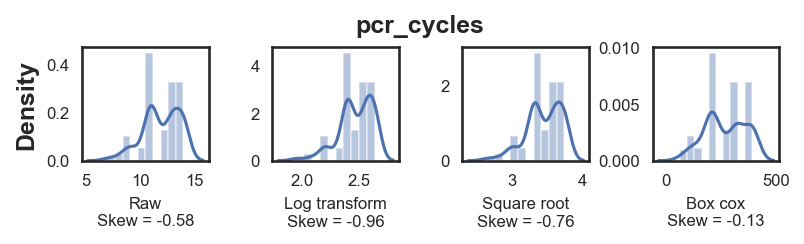

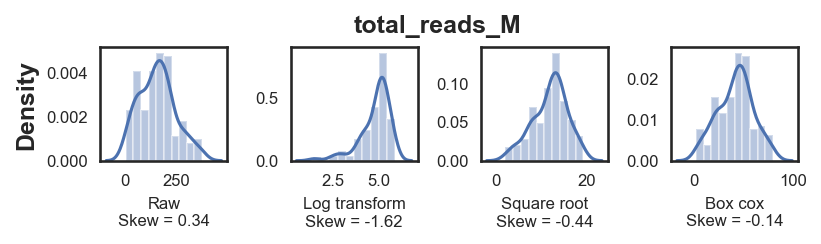

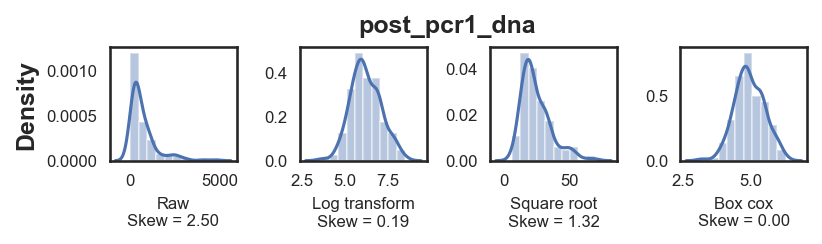

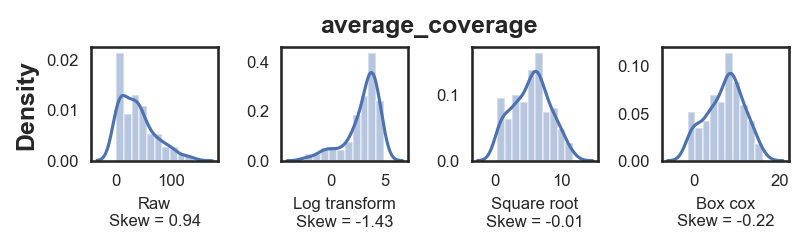

In [11]:
cont_features = ['pcr_cycles', 'total_reads_M', 'post_pcr1_dna', 'average_coverage']

fontsize = 8

for i in cont_features:
    
    fig, axes = plt.subplots(nrows=1, ncols=4, dpi=150, figsize=(6, 1))
    plt.subplots_adjust(wspace=0.5)

    # Raw data
    sns.distplot(data[i], bins=10, ax=axes[0])
    skew = data[i].skew()
    axes[0].set_xlabel('Raw\nSkew = {:.2f}'.format(skew), 
                       fontsize=fontsize)
    
    # Log transform
    sns.distplot(np.log(data[i]), bins=10, ax=axes[1])
    skew = np.log(data[i]).skew()
    axes[1].set_xlabel('Log transform\nSkew = {:.2f}'.format(skew), 
                       fontsize=fontsize)
    
    # Square root transform
    sns.distplot(np.sqrt(data[i]), bins=10, ax=axes[2])
    skew = np.sqrt(data[i]).skew()
    axes[2].set_xlabel('Square root\nSkew = {:.2f}'.format(skew), 
                       fontsize=fontsize)
    
    # Box-cox
    sns.distplot(scipy.stats.boxcox(data[i])[0], bins=10, ax=axes[3])
    skew = pd.Series(scipy.stats.boxcox(data[i])[0]).skew()
    axes[3].set_xlabel('Box cox\nSkew = {:.2f}'.format(skew), 
                       fontsize=fontsize)
    
    # Adjusting x-tick fontsize and ylabels for all axes
    for ax in axes:
        ax.tick_params(axis='both', which='major', labelsize=8, pad=0)
        ax.set_ylabel(None)
   
    axes[0].set_ylabel('Density', fontsize=12, fontweight='bold')
   
    plt.suptitle(i, y=1.1, fontsize=12, fontweight='bold')
    
    plt.show()

## 1.6 Normalizing the data:

In [12]:
# For box-cox normalization saving the lambda so that can apply to new input data as needed
lambda_dct = {}
data['pcr_cycles_norm'], lambda_dct['pcr_cycles'] = scipy.stats.boxcox(data['pcr_cycles'])
data['total_reads_norm'], lambda_dct['total_reads_M'] = scipy.stats.boxcox(data['total_reads_M'])
data['post_pcr1_dna_norm'], lambda_dct['post_pcr1_dna'] = scipy.stats.boxcox(data['post_pcr1_dna'])

data['average_coverage_norm'] = np.sqrt(data['average_coverage'])

In [13]:
with open('../boxcox_lambda_exponents.json', 'w') as convert_file:
     convert_file.write(json.dumps(lambda_dct))

In [14]:
data['kit'].unique()

array(['Ultra_II_NEB_FS', 'Swift 2S', 'XTHS'], dtype=object)

For the categorical variable kit, since there are three options and they need to be be transformed into a dummy variable, one of the kit types will need to be dropped.

In [15]:
data['kit_encoded'] = [1 if k == 'XTHS' else 0 for k in data['kit']]

---

# 2. Construct the multiple linear regression. <a class="anchor" id="model-data"></a>
**Modeling the average exome coverage based on:**
* Total reads
* PCR 1 cycles
* PCR 1 DNA yield
* Kit type used

In [16]:
formula = 'average_coverage_norm ~ total_reads_norm + pcr_cycles_norm + post_pcr1_dna_norm + kit_encoded'

# Using 70% of data to train and 30% to evaluate 
train, test = sklearn.model_selection.train_test_split(data, test_size=0.2, 
                                                       random_state=4)

# Fit model to training data
train_model = smf.ols(formula=formula, data=train).fit()

print(train_model.summary())

                              OLS Regression Results                             
Dep. Variable:     average_coverage_norm   R-squared:                       0.856
Model:                               OLS   Adj. R-squared:                  0.852
Method:                    Least Squares   F-statistic:                     189.3
Date:                   Mon, 07 Feb 2022   Prob (F-statistic):           1.69e-52
Time:                           09:35:39   Log-Likelihood:                -191.72
No. Observations:                    132   AIC:                             393.4
Df Residuals:                        127   BIC:                             407.8
Df Model:                              4                                         
Covariance Type:               nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Interc

Overall, the above model is predictive of mean coverage, all of the pre-sequencing metrics we have are useful in the prediction of average coverage. We are getting a multicollinearity warning, this was explored in another notebook but essentially adding in interaction terms for other correlated features (i.e. pcr_cycles and total reads), barely changed the model and still resulted in multi-collinearity warning. Additionally the variance inflation factor (VIF) was <= 2 for each of the features, so this is quite a minor violation of no multi-collinearity though something to be mindful of.

## Writing parameters of model to dictionary

In [17]:
model_params_dct = dict(train_model.params)
with open('../model_params.json', 'w') as convert_file:
     convert_file.write(json.dumps(model_params_dct))

---

# 3. Evaluate model. <a class="anchor" id="evaluate-model"></a>

## 3.1 Estimate overall goodness of fit
Using root mean squared error (RMSE) of coverage predictions by splitting the data 20:80 over 100 iterations

In [18]:
formula = 'average_coverage_norm ~ total_reads_norm + pcr_cycles_norm + post_pcr1_dna_norm + kit_encoded'

rmse_lst = []
predicted_all = []
observed_all = []

for i in range(0,100):
    
    train, test = sklearn.model_selection.train_test_split(data, test_size=0.2)

    # Fit model to training data
    test_model = smf.ols(formula=formula, data=train).fit()

    # Predict average coverage
    prediction = test_model.predict(test)

    # Both the prediction and the actual values of coverage will be squared 
    # since in the normalization the square root was taken 
    predicted_values = np.square(prediction)
    observed_values = np.square(test['average_coverage_norm'])
    
    # Measuring the root mean squared error RMSE
    rmse = np.sqrt(sklearn.metrics.mean_squared_error(observed_values, 
                                              predicted_values))
    rmse_lst.append(rmse)
                   
    predicted_all.extend(predicted_values)
    observed_all.extend(observed_values)

Plotting histogram of RMSE over all iterations

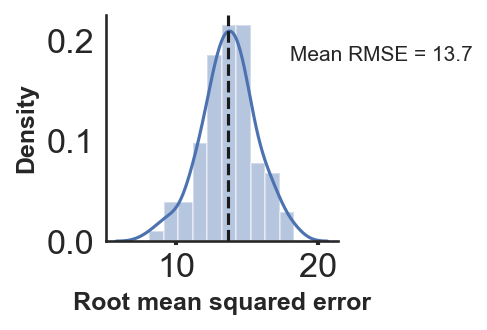

In [19]:
plt.figure(figsize=(2,2), dpi=150)

sns.distplot(rmse_lst, bins=10)

plt.xlabel('Root mean squared error', fontweight='bold', fontsize=12)
plt.ylabel('Density', fontweight='bold', fontsize=12)

sns.despine(right=True)

plt.tick_params(axis='both', which='major', size=2, width=2, 
                direction='out', bottom='on')

plt.axvline(x=np.average(rmse_lst), linestyle='--', color='k')

plt.text(18, 0.18, 'Mean RMSE = {:.3}'.format(np.average(rmse_lst)), 
         fontsize=10)

plt.savefig('figures/RMSE_average_coverage.pdf', dpi=150, bbox_inches='tight')
plt.show()

Over 100 different iterations of cross validation, we estimated the average RMSE of the predicted average exome coverage to be 13.7. For the application of deciding which libraries to sequence, this is a fairly reasonable error.

To get a more intuitive understanding of the relationship between predicted and observed over cross-validation, this is a visualization of predicted coverage versus observed.

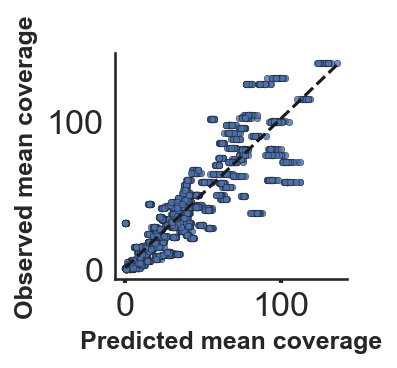

In [20]:
plt.figure(figsize=(2,2), dpi=150)

sns.scatterplot(y=observed_all, 
                x=predicted_all, 
                s=10, 
                alpha=0.8, 
                edgecolor='k')

plt.ylabel('Observed mean coverage', fontweight='bold', fontsize=12)
plt.xlabel('Predicted mean coverage', fontweight='bold', fontsize=12)

x = predicted_all
y = observed_all

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), 
         color='k', linestyle='--')

sns.despine(right=True)

plt.tick_params(axis='both', which='major', size=2, width=2, 
                direction='out', bottom='on')

plt.savefig('figures/Cross_validation_scatter.pdf', dpi=150, bbox_inches='tight')
plt.show()

## 3.2 Measure the "importance" of each feature

Quantifying the contribution of each variable to the predictive performance by removing that variable and evaluating the partial model.

In [21]:
model = smf.ols(formula=formula, data=data).fit()
total_rsquared_adj = model.rsquared_adj

rsquared_adj_lst = []
rsquared_adj_params = ['Reads', 'PCR cycles', 'PCR yield', 'Kit' , 'PCR cycles and yield']

for f in ['average_coverage_norm ~ pcr_cycles_norm + post_pcr1_dna_norm + kit_encoded', 
          'average_coverage_norm ~ total_reads_norm + post_pcr1_dna_norm + kit_encoded', 
          'average_coverage_norm ~ total_reads_norm + pcr_cycles_norm + kit_encoded', 
          'average_coverage_norm ~ total_reads_norm + pcr_cycles_norm + post_pcr1_dna_norm', 
          'average_coverage_norm ~ total_reads_norm + kit_encoded']:
    
    model = smf.ols(formula=f, data=data).fit()
    rsquared_adj = model.rsquared_adj
    rsquared_adj_lst.append(rsquared_adj)

model_eval_df = pd.DataFrame(zip(rsquared_adj_params, rsquared_adj_lst), 
                             columns=['variable', 'rsquared_adj'])

model_eval_df['delta_rsquared_adj'] = total_rsquared_adj - model_eval_df['rsquared_adj']
model_eval_df['total_rsquared_adj'] = total_rsquared_adj

model_eval_df = model_eval_df.sort_values(by='rsquared_adj')

Plotting the results each of the variable drops.

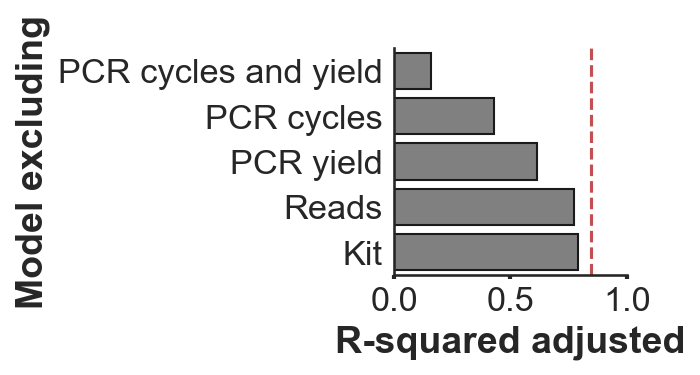

In [22]:
plt.figure(figsize=(2,2), dpi=150)

sns.barplot(data=model_eval_df, 
            y='variable', 
            x='rsquared_adj', 
            color='grey', 
            edgecolor='k')

plt.xlabel('R-squared adjusted', fontweight='bold')
plt.ylabel('Model excluding', fontweight='bold')

sns.despine(right = True)

plt.tick_params(axis='both', which='major', size=2, width=2, 
                direction='out', bottom='on')

plt.xlim(0, 1)
plt.axvline(x=total_rsquared_adj, color='r', linestyle='--')

plt.savefig('figures/Rsquared_adj_variable_Eval.pdf', dpi=150, bbox_inches='tight')

Overall, models excluding PCR yield or excluding PCR cycles, had the largest decrease in accuracy, $R^{2}$=0.61 and 0.43 respectively, with the removal of both resulting in $R^{2}$=0.16, suggesting these had the greatest contribution in the prediction.

---

## Conclusion: 
Overall here I developed and trained an exome sequencing depth prediction model trained on pre-sequencing metrics from 166 library preparation conditions, varying sample (*N=124*), input DNA (2-309ng) or library kit (*N=3*). A limited set of parameters (kit, reads, PCR cycles, and PCR yield) were predictive of mean exome depth ($R^{2}$=0.85). Despite the extreme variability of FFPE derived DNA quantity and quality, as well as many other factors that contribute to sequencing performance excluded from this model, there is reasonable coverage predictions from very limited measurements that do not require sample sequencing. This model will be used as the basis of a shared web-application to assist experimental users in quality assessment prior to sequencing.